# Initial loss stats

I noticed a weird trend in the last tensorboards: the initial loss of the model is almost always greater on the reversed (i.e. labeled `backward`) dataset than in non-reversed one (labeled `forward`).
This looks suspicious, because for randomly initialized weights, the untrained model's loss should be, on average, equal on `forward` and on `backward` datasets.

Most likely explanation is, the first point on my tensorboard learning curve plots corresponds to the loss _after the first epoch_, i.e. after some training has already been done.
Maybe I should call my tensorboard callback just before the training loop to add the true initial point.

Anyway, I explore this trend more rigorously in this notebook.

In [1]:
# Custom code imports
from models import ThreeFullyConnectedLayers

from generate_time_series import (load_two_body_problem_time_series,
                                  load_lorenz_attractor_time_series,
                                  load_belousov_zhabotinsky_time_series)

from datasets import (prepare_time_series_for_learning,
                      time_series_to_dataset,
                      AllDataHolder)

from train_test_utils import get_mean_loss_on_test_dataset

In [239]:
# Standard modules import
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

In [3]:
# Dataholders
def load_two_body_problem_dataholder(window_len: int,
                                     target_len: int) -> AllDataHolder:
    twb = load_two_body_problem_time_series()
    dh = prepare_time_series_for_learning(train_ts=twb,
                                          test_ts=twb.copy(),
                                          window_len=window_len,
                                          target_len=target_len,
                                          take_each_nth_chunk=1)
    return dh


def load_lorenz_attractor_dataholder(window_len: int,
                                     target_len: int) -> AllDataHolder:
    lrz = load_lorenz_attractor_time_series()
    dh = prepare_time_series_for_learning(train_ts=lrz,
                                          test_ts=lrz.copy(),
                                          window_len=window_len,
                                          target_len=target_len,
                                          take_each_nth_chunk=1)
    return dh


def load_belousov_zhabotinsky_dataholder(window_len: int,
                                         target_len: int) -> AllDataHolder:
    bzh = load_belousov_zhabotinsky_time_series()
    dh = prepare_time_series_for_learning(train_ts=bzh,
                                          test_ts=bzh.copy(),
                                          window_len=window_len,
                                          target_len=target_len,
                                          take_each_nth_chunk=1)
    return dh

In [131]:
def get_loss_difference(model: ThreeFullyConnectedLayers,
                        dh: AllDataHolder) -> float:
    loss_forw = get_mean_loss_on_test_dataset(model, dh.forward.test_dataset)
    loss_back = get_mean_loss_on_test_dataset(model, dh.backward.test_dataset)
    return loss_back - loss_forw

def get_loss_difference_kepler(window_len: int = 20,
                               target_len: int = 1,
                               size: int = 7) -> float:
    dh = load_two_body_problem_dataholder(window_len=window_len,
                                          target_len=target_len)
    m = ThreeFullyConnectedLayers(window_len=window_len, target_len=target_len,
                                  hidden_layer1_size=size, hidden_layer2_size=size,
                                  datapoint_size=2)
    return get_loss_difference(m, dh)

def get_loss_difference_lorenz(window_len: int = 20,
                               target_len: int = 1,
                               size: int = 10) -> float:
    dh = load_lorenz_attractor_dataholder(window_len=window_len,
                                          target_len=target_len)
    m = ThreeFullyConnectedLayers(window_len=window_len, target_len=target_len,
                                  hidden_layer1_size=size, hidden_layer2_size=size,
                                  datapoint_size=3)
    return get_loss_difference(m, dh)

def get_loss_difference_belousov_zhabotinsky(window_len: int = 20,
                                             target_len: int = 1,
                                             size: int = 10) -> float:
    dh = load_belousov_zhabotinsky_dataholder(window_len=window_len,
                                              target_len=target_len)
    m = ThreeFullyConnectedLayers(window_len=window_len, target_len=target_len,
                                  hidden_layer1_size=size, hidden_layer2_size=size,
                                  datapoint_size=3)
    return get_loss_difference(m, dh)

In [206]:
%%time 
get_loss_difference_kepler()

CPU times: user 873 ms, sys: 0 ns, total: 873 ms
Wall time: 793 ms


-9.962953055997481e-05

In [164]:
%%time
_ = load_two_body_problem_dataholder(window_len=20, target_len=1)

CPU times: user 46.4 ms, sys: 3.22 ms, total: 49.6 ms
Wall time: 21.4 ms


In [178]:
%%time
_ = ThreeFullyConnectedLayers(window_len=20, target_len=1,
                              hidden_layer1_size=10, hidden_layer2_size=10,
                              datapoint_size=3)

CPU times: user 933 µs, sys: 4 µs, total: 937 µs
Wall time: 651 µs


### As you can see, evaluation of the model takes wastly more time than creating the model and generating the dataset.
### So, the next cell is going to take minutes.

In [184]:
losses_kepler = [get_loss_difference_kepler() for _ in range(1000)]
losses_lorenz = [get_loss_difference_lorenz() for _ in range(1000)]
losses_bzh = [get_loss_difference_belousov_zhabotinsky() for _ in range(1000)]

In [240]:
def initial_loss_histogram(losses, title_suffix: str = "",
                           set_xlims: bool = False, bins: Optional[int] = None) -> None:
    if bins is not None:
        plt.hist(losses, bins=bins)
    else:
        plt.hist(losses)
    
    if set_xlims:
        plt.xlim(min(0, min(losses_bzh)), max(0, max(losses_bzh)))
        
    plt.grid()
    plt.title("Initial loss difference (backward minus forward)\ndistribution on " + title_suffix)
    plt.xlabel("initial loss")
    plt.ylabel("count")
    
    plt.show()

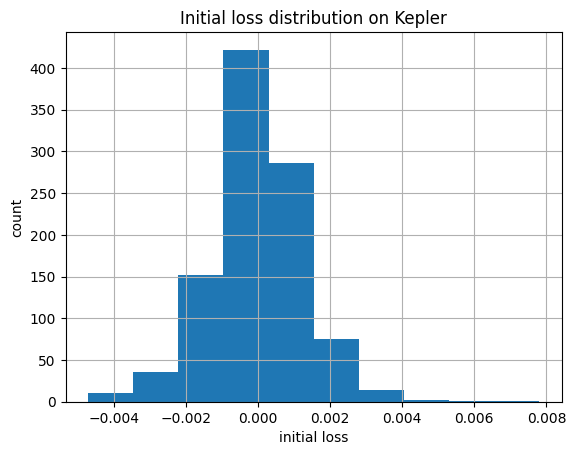

In [241]:
initial_loss_histogram(losses_kepler, "Kepler")

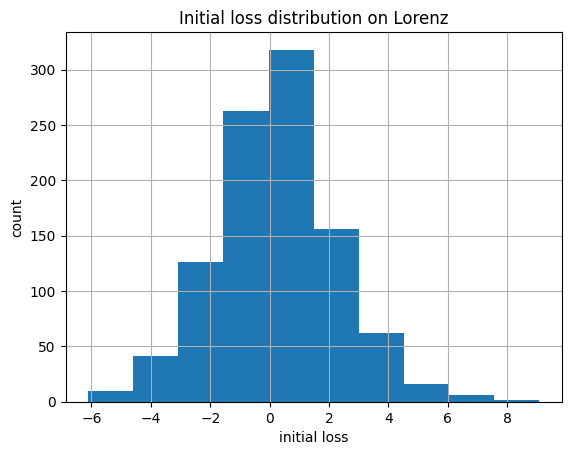

In [221]:
initial_loss_histogram(losses_lorenz, "Lorenz")

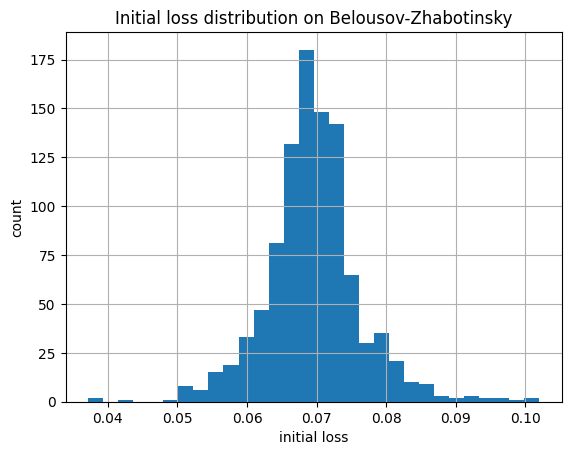

In [244]:
initial_loss_histogram(losses_bzh, "Belousov-Zhabotinsky", bins=30)

In [236]:
def mean_pm_std(array) -> str:
    return f"{np.mean(array):.2e} ± {np.std(array):.2e}"

print("Kepler:", mean_pm_std(losses_kepler))
print("Lorenz:", mean_pm_std(losses_lorenz))
print("Belousov-Zhabotinsky:", mean_pm_std(losses_bzh))

Kepler: -1.18e-05 ± 1.27e-03
Lorenz: 2.52e-01 ± 2.07e+00
Belousov-Zhabotinsky: 6.95e-02 ± 6.88e-03


### Kepler&Lorenz are fine, i.e. centered at zero. But Belousov-Zhabotinsky??